In [ ]:
# install requirements if using Google CoLab
! pip install beautifulsoup4
! pip install nltk

In [ ]:
from bs4 import BeautifulSoup
import csv
import json
import math
import numpy as np
import pandas as pd
import re
import requests
from urllib.request import urlopen,Request
import collections
import pandas as pd
import nltk
nltk.download('punkt')
import time

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 1. Functions for Scraping

In [ ]:
# scrape 1st google search page - get all urls
def get_google_urls(drug_name,company_name,keywords_list):
    urls = []
    for keyword in keywords_list:
        # google search 
        search_word = drug_name+" "+re.sub('\W+',' ', company_name) + " " + keyword
        search_word = search_word.replace(" ","+")
        gg_url = "https://www.google.com/search?q=+"+search_word
        #print(gg_url)
        # get urls
        #soup = BeautifulSoup(requests.get(gg_url).content, "html.parser")
        req = Request(gg_url, headers={'User-Agent': 'Mozilla/5.0'})
        page = urlopen(req)
        html = page.read().decode("utf-8")
        soup = BeautifulSoup(html, "html.parser")
        #print(soup)
        links = [a['href'] for a in soup.find_all('a', href=True) if a.text]
        for div in soup.find_all("div", {"class": "kCrYT"}): #"yuRUbf"
            if div.find('a'):
                if(len(div.find('a')['href'].split("q="))>1):
                    url = div.find('a')['href'].split("q=")[1].split("&")[0].split("%23")[0]
                    if "patent" in url or "http" not in url or "pdf" in url or "linkedin" in url:
                        continue
                    urls.append( url )
      # return urls 
        time.sleep(8)
    return set(urls)

In [ ]:
#get_google_urls(drug_name,company_name,keywords_list)

In [ ]:
# extract all sentences containing keywords from a webpage 
def get_sentences(url,keywords_list):
  # get all texts from a webpage 
  #print(url)
  req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
  try:
    page = urlopen(req)
    html = page.read().decode("utf-8")
    soup = BeautifulSoup(html, "html.parser")
    #soup = BeautifulSoup(requests.get(url,verify=False).content, "html.parser")
    text = soup.get_text()
    # separate texts into sentences 
    sentences = nltk.sent_tokenize(text)
    # extract sentences with keywords 
    result = [sentence for sentence in sentences if any(keyword in sentence for keyword in keywords_list)]
    # return list of senteces
    return result 
  except:
    return []

## 1.1 Testing

In [ ]:
drug_name = "AZD2014"
company_name = "Samsung Medical Center"
keywords_list = ["abandon","terminat","clos","safe","money","stop","end","pass"]
#keywords_list = ["abandon","terminate"]

In [ ]:
# run 
urls = get_google_urls(drug_name,company_name,keywords_list)
corpus = []
for url in urls:
  corpus = corpus + get_sentences(url,keywords_list)
  #time.sleep(5)

In [ ]:
set(corpus)
#print(urls)

# 2. Get Reasons for Selected Clinical Trials

In [ ]:
# get labelled data from csv

#file_name = "/content/Selected data_4000_6000 - Sheet1.csv"
#sheet = "final_final"
#df = pd.read_csv(file_name,sheet_name=sheet)
file_name = "Data/clinical_trials_selected/clinicaltrials_data_0_2000_selected.csv"
df = pd.read_csv(file_name)

# get drug and company names lists 
drug_names = df["Interventions"].str.replace("Drug:","").str.replace(","," ").str.replace("|"," ").str.split().str.get(0)
company_names = df["Sponsor/Collaborators"].str.split("|").str.get(0)
df["Reasons_corpus"] = np.nan

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# keywords 
#keywords_list = ["abandon","terminat","clos","safe","money","stop","end","pass"]
keywords_list = ["abandon","terminat","discontinue","close"]

In [ ]:
# hide warnings
import warnings
warnings.filterwarnings('ignore')

# run 
n = len(drug_names)
#n = 3
for i in range(n):
    drug_name = drug_names[i]
    company_name = company_names[i]
    print(str(i+1)+"."+drug_name +": ",end="")
    urls = get_google_urls(drug_name,company_name,keywords_list)
    print(len(urls)," urls to process",end="")
    corpus = []
    for url in urls:
        corpus = corpus + get_sentences(url,keywords_list)
        print(".",end="")
    df["Reasons_corpus"][i] = [c.replace('\n',' ').replace('\t',' ').replace('\r',' ').replace('\xa0',' ') for c in set(corpus)]
    print("done")


1.GO-203-2C: 24  urls to process........................done
2.AMT2003: 13  urls to process.............done
3.TAK-659: 21  urls to process.....................done
4.MDG1021: 20  urls to process....................done
5.ONO-7746: 23  urls to process.......................done
6.AEG35156: 22  urls to process......................done
7.U3-1287: 19  urls to process...................done
8.L19-IL2: 19  urls to process...................done
9.ADH300004: 20  urls to process....................done
10.Biological:: 37  urls to process.....................................done
11.Biological:: 31  urls to process...............................done
12.Azacitidine: 23  urls to process.......................done
13.RTA: 25  urls to process.........................done
14.XL999: 21  urls to process.....................done
15.AMG: 34  urls to process.............................

In [ ]:
# save as csv
csv_name = "Results/corpus/clinicaltrials_0_2000_selected_reasons.csv"
df.to_csv(csv_name,index=False)

# 3. Word Cloud

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


In [ ]:
# generate and save all word clouds 

n = len(drug_names)
for i in range(n):
    text = str(df["Reasons_corpus"][i])
    stopwords = set(STOPWORDS)
    if len(df["Reasons_corpus"][i])>0:
        wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=100, background_color="white").generate(text)
        wordcloud.to_file('Results/wordclouds/'+str(df["Rank"][i])+"_"+drug_names[i]+'.png')

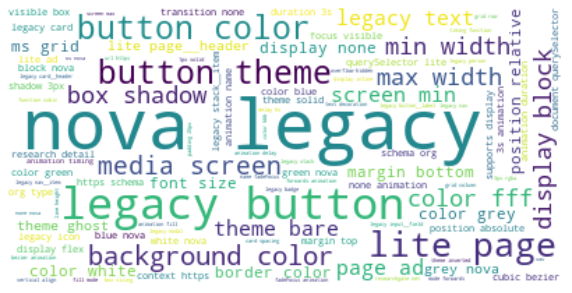

In [ ]:
# plot and save all word clouds 
text = list(corpus)
text = str(text)
stopwords = set(STOPWORDS)
def gen_wc():
  stopwords = set(STOPWORDS)
  for i in range(len(df["Reasons_corpus"])):
    wordcloud = WordCloud(stopwords=stopwords,max_font_size=50, max_words=100, background_color="white").generate(df["Reasons_corpus"][i])
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    name = df["Interventions"][i]
    plt.savefig(name+".png")